In [1]:
import time
import random
import numpy as np
import torch
import json

import messages
from agent import Agent
from unity_env import UnityEnv
from server import Server

import matplotlib.pyplot as plt

In [2]:
serv = Server(host="127.0.0.1", port=5004)

In [3]:
env = UnityEnv(serv, 7, 2, 1, lambda n: 2*np.random.random((n, 2))-1, "SimpleUnityEnv", 2)
agent = Agent(env, (256,)*6, (256)*6)

In [ ]:
cp = torch.load(f"save/{env.get_name()}/checkpoint.pt")
agent.policy.load_state_dict(cp['pi'])
agent.q1.load_state_dict(cp['q1'])
agent.q2.load_state_dict(cp['q2'])
agent.replay_buffer = cp["replay_buffer"]
from_epoch = cp['epoch']

In [4]:
env.start_server()


Accepted connection from <server.Client object at 0x7fbf685a7520> (('127.0.0.1', 42422))


In [6]:
env.set_time_scale(1)

In [5]:
agent.train(from_epoch=0, epoch_len=10_000, start_steps=10_000, max_episode_len=4_000)

ValueError: could not broadcast input array from shape (2,2) into shape (1,2)

In [ ]:
ts_message = messages.SingleFieldMessage(20)
message = messages.RequestMessage("timeScale", ts_message.to_json())
message = messages.RequestMessage("shutdown", "")
data = message.to_json().encode()
data, (pre_data:=(len(data).to_bytes(4, 'little', signed=False))+data), len(data)

In [ ]:
# stress test client :
env.resume()
x = []
y1 = []
y2 = []
n = 200
for ts in range(1, 25):
    env.set_time_scale(ts)
    env.reset()
    t0 = time.time()
    for _ in range(n):
        #env.pause()
        #env.resume()
        env.step((1, 1))
    t1 = time.time()
    print(f"ts : {ts} || {1000*(t1-t0)/n:.2f}msec/step (target={20/ts:.2f})")
    x.append(ts)
    y1.append(1000*(t1-t0)/n)
    y2.append(20/ts)
env.shutdown()
serv.clients = []

Accepted connection from <server.Client object at 0x7f3b5025b0a0> (('127.0.0.1', 35218))
Accepted connection from <server.Client object at 0x7f3a7625b970> (('127.0.0.1', 35314))


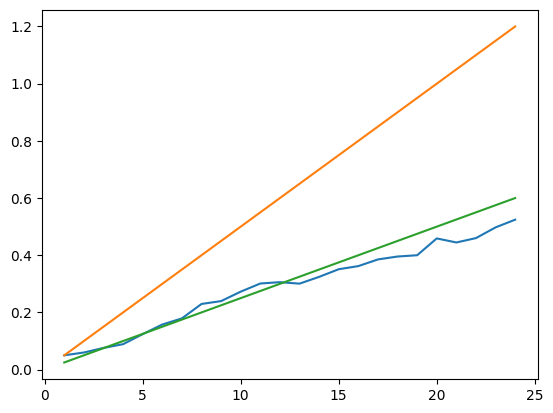

Accepted connection from <server.Client object at 0x7f7c8c1807f0>


In [102]:
plt.plot(x, [1/z for z in y1])
plt.plot(x, [1/z for z in y2])
plt.plot(x, [0.5/z for z in y2])
plt.show()

In [7]:
serv.stop_server()

In [6]:
env.shutdown()

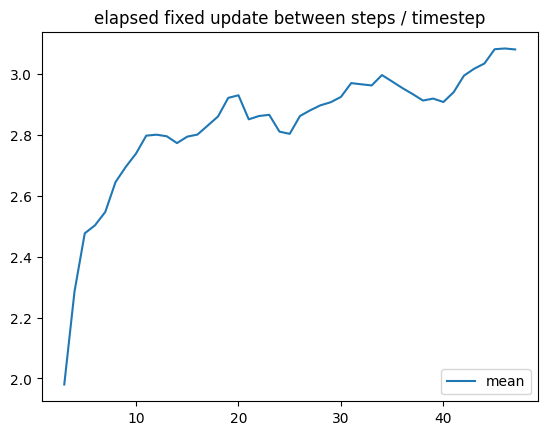

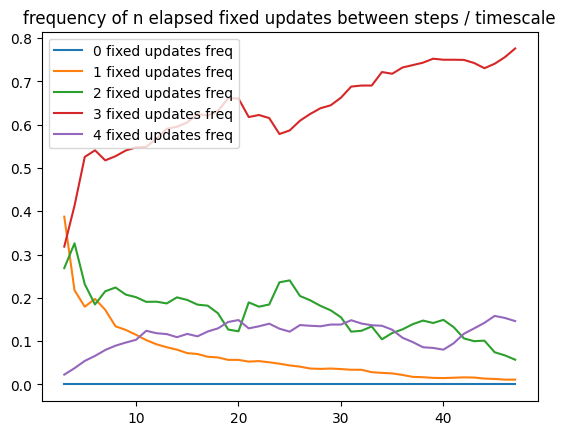

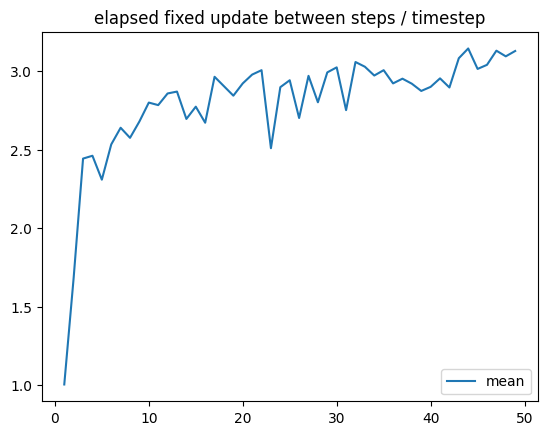

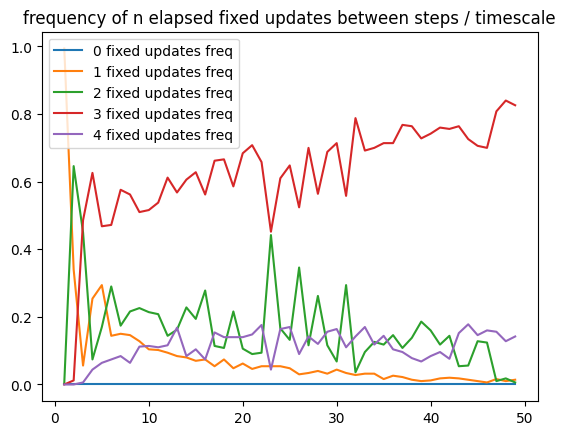

Accepted connection from <server.Client object at 0x7f3ce2735870> (('127.0.0.1', 60012))


In [155]:
"""mean = []
l_ts = []
n = 500

for ts in range(1, 50):
    env.set_time_scale(ts)
    obs = env.reset(envDone=(True, True))
    for i in range(n):
        env.step(((0.5,1), (0.5, 1)))
    l = get_elapsed(env)
    mean.append(sum(i*w for i, w in enumerate(l))/sum(l))
    l_ts.append(l)
"""
x = list(range(1, 50))
x_ = list(range(3, 48))

def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.title("elapsed fixed update between steps / timestep")
plt.plot(x_, moving_average(mean), label="mean")
plt.legend(loc="lower right")
plt.show()

plt.title("frequency of n elapsed fixed updates between steps / timescale")
for i, elapsed in enumerate(zip(*l_ts)):
    plt.plot(x_, moving_average([e/n for e in elapsed]), label=f"{i} fixed updates freq")
    if i>=4:break
plt.legend(loc="upper left")
plt.show()


plt.title("elapsed fixed update between steps / timestep")
plt.plot(x, mean, label="mean")
plt.legend(loc="lower right")
plt.show()

plt.title("frequency of n elapsed fixed updates between steps / timescale")
for i, elapsed in enumerate(zip(*l_ts)):
    plt.plot(x, ([e/n for e in elapsed]), label=f"{i} fixed updates freq")
    if i>=4:break
plt.legend(loc="upper left")
plt.show()

In [62]:
obs = env.step(((0, 0), (0, 0)))
print(obs)
print(obs.messages[0])
print(obs.messages[1])
#for _ in range(5):
#    env.step((1,5))
#env.step((0,0))

MultiObservationMessage({'messages': [ObservationMessage({'agentPostion': {'x': 0.5111274719238281, 'y': 0.3020021915435791, 'z': -6.143032073974609}, 'agentRotation': {'x': 0.18883132934570312, 'y': 275.8118896484375, 'z': 359.9870300292969}, 'velocity': {'x': -8.009427070617676, 'y': 0.02870190143585205, 'z': -1.570563793182373}, 'angularVelocity': {'x': 0.008384069427847862, 'y': 0.0033472406212240458, 'z': -0.03477317839860916}, 'redBallPosition': {'x': -0.453369140625, 'y': 0.25, 'z': -3.736520767211914}, 'blueBallPosition': {'x': 0.9334774017333984, 'y': -10.0, 'z': 2.549999952316284}, 'greenBallPosition': {'x': 0.9334774017333984, 'y': -10.0, 'z': -4.090000152587891}, 'grayAreaPosition': {'x': -3.1437435150146484, 'y': 0.009999999776482582, 'z': 0.477963924407959}, 'orangeAreaPosition': {'x': 5.53000020980835, 'y': -10.0, 'z': 3.6500000953674316}, 'whiteAreaPosition': {'x': -6.53000020980835, 'y': -10.0, 'z': -0.33574599027633667}, 'agentRedBallAngle': 62.34979248046875, 'agentG

In [28]:
controll_message = messages.ControllMessage(0,0, 0)
message = messages.RequestMessage("step", controll_message.to_json())

serv.send(message.to_json())

response = messages.ResponseMessage.from_json(serv.receive())
messages.ObservationMessage.from_json(response.value).to_json()

'{"agentPostion": {"x": 1.0539418458938599, "y": 0.29999998211860657, "z": -6.657251358032227}, "agentRotation": {"x": -3.7150846310396446e-06, "y": 293.3022766113281, "z": 3.052026613659109e-07}, "velocity": {"x": -3.518006224112469e-07, "y": -5.960464477539063e-08, "z": 9.424678069080983e-07}, "angularVelocity": {"x": 2.3306704406422796e-06, "y": -1.7303534605161985e-07, "z": 1.5920276155156898e-06}, "redBallPosition": {"x": 1.1032094955444336, "y": 0.25, "z": -1.657907247543335}, "blueBallPosition": {"x": 0.9334774613380432, "y": -10.0, "z": 2.549999952316284}, "greenBallPosition": {"x": 0.9334774613380432, "y": -10.0, "z": -4.090000152587891}, "grayAreaPosition": {"x": -2.094573736190796, "y": 0.009999999776482582, "z": 2.1858127117156982}, "orangeAreaPosition": {"x": 5.53000020980835, "y": -10.0, "z": 3.6500000953674316}, "whiteAreaPosition": {"x": -6.53000020980835, "y": -10.0, "z": -0.3357459604740143}, "agentRedBallAngle": 67.26354217529297, "agentGrayAreaAngle": 47.12516021728

Accepted connection from <server.Client object at 0x7f3b5025be50> (('127.0.0.1', 54638))
Accepted connection from <server.Client object at 0x7f3a7625b940> (('127.0.0.1', 51694))
Accepted connection from <server.Client object at 0x7f3b5025b0a0> (('127.0.0.1', 48862))


In [1]:
import messages as msg
l = [msg.ControllMessage(6, 9, 0) for i in range(3)]
mm = msg.MultiControllMessage(l)

print(mm.to_json())
print([(m) for m in  msg.MultiControllMessage.from_json(mm.to_json()).messages])

{
    "messages": [
        {
            "moveInput": 6.0,
            "turnInput": 9.0,
            "envNum": 0
        },
        {
            "moveInput": 6.0,
            "turnInput": 9.0,
            "envNum": 0
        },
        {
            "moveInput": 6.0,
            "turnInput": 9.0,
            "envNum": 0
        }
    ]
}
[ControllMessage({'moveInput': 6.0, 'turnInput': 9.0, 'envNum': 0}), ControllMessage({'moveInput': 6.0, 'turnInput': 9.0, 'envNum': 0}), ControllMessage({'moveInput': 6.0, 'turnInput': 9.0, 'envNum': 0})]


In [14]:
class A:
    var = 123
    @classmethod
    @property
    def meth(cls):
        return cls.var
    
class B(A):

    def meth(cls):
        return cls    
A.meth, B.meth

(<bound method A.meth of <class '__main__.A'>>,
 <function __main__.B.meth(cls)>)

In [52]:
from unity_env import get_json_request, get_response_msg
d = np.array([True, True])
l = np.where(d)

print(d)
print(l)
print(messages.MultiMessage(list(l[0])))
print(get_json_request("multiReset", messages.MultiMessage(list(l[0]))))

[ True  True]
(array([0, 1]),)
MultiMessage({'messages': [0, 1]})
{
    "api": "multiReset",
    "parameter": "{\n    \"messages\": [\n        null,\n        null\n    ]\n}"
}


In [54]:
a = np.array([0, 1, 2, 3], dtype=np.float32)
json.dumps(a.tolist())

'[0.0, 1.0, 2.0, 3.0]'

In [90]:
from unity_env import get_json_request, get_response_msg

def get_elapsed(self):
    req_json = get_json_request("elapsedFU", messages.SingleFieldMessage(0))
    self.server.send(req_json)
    resp_json = self.server.receive()
    return get_response_msg(resp_json, messages.MultiMessage).messages

